# Goal of notebook
- create two dataframes, one for nodes and one for edges
- the nodes dataframe needs everything from create_final network, and adds information on population density, median income, education level, job availability (unclear whether for results or for optimisation), school availability (same here)


In [1]:
import pandas as pd
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import osmnx as ox
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'
import osmnx as nx
import shapely
import multiprocess as mp
import numpy as np
import math

crs_fr = 2154



In [2]:
# --- From Anastassia
# import packages
%run -i packages.py

# CUSTOM FUNCTION

# define function that creates attribute dictionary for nodes and edges
# (for input to nx.add_edges_from/add_nodes_from)
def make_attr_dict(*args, **kwargs): 
    
    argCount = len(kwargs)
    
    if argCount > 0:
        attributes = {}
        for kwarg in kwargs:
            attributes[kwarg] = kwargs.get(kwarg, None)
        return attributes
    else:
        return None # (if no attributes are given)

In [3]:
#--- Get relevant shapes and data

# GPM outline
GPM = gpd.read_file('data/raw/GPM.geojson').to_crs(crs_fr)

# IRIS codes and shapes 
IRIS_GPM = gpd.read_file('data/raw/IRIS_GPM.geojson')
IRIS_GPM['CODE_IRIS'] = IRIS_GPM['CODE_IRIS'].astype('string')

# Communes (and filter for GPM)
communes = gpd.read_file('data/raw/commune-frmetdrom/COMMUNE_FRMETDROM.shp').to_crs(crs_fr)
communes['point'] = communes['geometry'].centroid
communes = communes.set_geometry('point')
communes_GPM = gpd.sjoin(communes, GPM, how='inner', op='intersects').set_geometry('geometry')
communes_GPM = communes_GPM[['NOM', 'INSEE_COM', 'geometry']]

/Users/auriane/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3400: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


# Number of schools per IRIS

In [4]:
#--- Get education-related amenities from OSM

# Define tags
tags = {'amenity': 'school'}
place_name = 'Grand Paris Metropolis, France'

# Get the data
buildings = ox.geometries_from_place(place_name, tags).reset_index(drop=False)

# Keep relevant columns
col_tokeep = ['osmid', 'geometry', 'amenity', 'name', 'school:FR']
buildings = buildings[col_tokeep].to_crs(IRIS_GPM.crs)
buildings.shape

(4337, 5)

In [5]:
#--- Group by type and by IRIS

# Only keep buildings with some sort of name (so they can be checked)
buildings['name'] = buildings['name'].fillna(buildings['school:FR'])
buildings_notnull = buildings.loc[buildings['name'].notnull()].drop_duplicates(subset=['geometry'], keep='first').drop(columns = ['school:FR', 'osmid'])
len(buildings_notnull)

# Prep the tables
buildings_notnull['geometry'] = buildings_notnull['geometry'].centroid
buildings_notnull = buildings_notnull.drop(columns = 'name')

# Perform the spatial join
joined_table = gpd.sjoin(buildings_notnull, IRIS_GPM, how = 'right', predicate='within')

# Find buildings that are close to the border
unmatched_buildings = buildings_notnull[~buildings_notnull.index.isin(joined_table['index_left'])]
buffer_distance = 50 
unmatched_buildings['geometry'] = unmatched_buildings.buffer(buffer_distance)
buffer_gdf = gpd.GeoDataFrame(unmatched_buildings ,geometry='geometry', crs=buildings_notnull.crs)

# Add missing buildings to the table
buffer_joined_table = gpd.sjoin(buffer_gdf, IRIS_GPM, how = 'right')
buffer_joined_table.isnull().sum()
joined_table = pd.concat([joined_table, buffer_joined_table], ignore_index=True).drop(columns = ['index_left'])

# Count the number of each building amenity in each IRIS
pivot_table = joined_table.pivot_table(index='CODE_IRIS', columns='amenity', aggfunc='count', fill_value=0)
pivot_table.columns = pivot_table.columns.map(lambda x: f'{x[1]}_count')
pivot_table = pivot_table.reset_index()

# Add geometry
final_table = pivot_table.merge(IRIS_GPM[['CODE_IRIS', 'geometry']], on='CODE_IRIS', how = 'right').fillna(0)

# turn everything except the geometry to int64 type
final_table.iloc[:, 0:-1] = final_table.iloc[:, 0:-1].astype('int64')
final_table = final_table.loc[:,~final_table.columns.duplicated()].copy()

education_perIRIS = final_table
education_perIRIS.head(2)

/var/folders/2m/lkz691q11b72bpprh6_v34_h0000gn/T/ipykernel_2884/3253410749.py:35: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  final_table.iloc[:, 0:-1] = final_table.iloc[:, 0:-1].astype('int64')


,CODE_IRIS,school_count,geometry
0,920440109,3,"POLYGON ((648055.600 6866209.000, 648025.400 6..."
1,930270105,1,"POLYGON ((656803.300 6869116.600, 656753.200 6..."


In [6]:
education_perIRIS.dtypes

CODE_IRIS          int64
school_count       int64
geometry        geometry
dtype: object

In [7]:
education_perIRIS.shape

(2666, 3)

# Available jobs per IRIS

In [8]:
df = pd.read_csv('data/raw/etablissements-et-effectifs-salaries-au-niveau-commune-x-ape-last.csv', sep=';')

# Fix the Commune names and codes
df['Code commune'] = df.Commune.apply(lambda x: x[:5])
df['Commune'] = df.Commune.apply(lambda x: x[6:])

# Only keep those in GPM
df_GPM = df.loc[df['EPCI'] == 'Métropole du Grand Paris']

# Clean up a bit
col_todrop  = ['Région', 'Ancienne région', 'Département','EPCI',
       'Secteur NA17', 'Secteur NA38', 'Secteur NA88', 'APE', 'Code région',
       'Code ancienne région', 'Code département',
       'Code EPCI', 'Code APE']
df_GPM = df_GPM.drop(col_todrop, axis = 1)

In [9]:
# One row per commune in GPM
df_GPM_grouped = df_GPM.groupby(['Commune' , 'Zone d\'emploi', 'Code zone d\'emploi', 'Code commune']).sum(numeric_only = True).sort_values(by = 'Effectifs salariés 2018').reset_index().drop(0)
df_GPM_grouped.isnull().sum() #Pick 2021

Commune                         0
Zone d'emploi                   0
Code zone d'emploi              0
Code commune                    0
﻿Code commune                   0
Nombre d'établissements 2006    0
Effectifs salariés 2006         0
Nombre d'établissements 2007    0
Effectifs salariés 2007         0
Nombre d'établissements 2008    0
Effectifs salariés 2008         0
Nombre d'établissements 2009    0
Effectifs salariés 2009         0
Nombre d'établissements 2010    0
Effectifs salariés 2010         0
Nombre d'établissements 2011    0
Effectifs salariés 2011         0
Nombre d'établissements 2012    0
Effectifs salariés 2012         0
Nombre d'établissements 2013    0
Effectifs salariés 2013         0
Nombre d'établissements 2014    0
Effectifs salariés 2014         0
Nombre d'établissements 2015    0
Effectifs salariés 2015         0
Nombre d'établissements 2016    0
Effectifs salariés 2016         0
Nombre d'établissements 2017    0
Effectifs salariés 2017         0
Nombre d'établ

In [10]:
# Finish removing useless columns
col_tokeep = ['Commune', 'Code commune', 'Nombre d\'établissements 2021', 'Effectifs salariés 2021']
df_GPM_grouped = df_GPM_grouped[col_tokeep]

# Fix column types
df_GPM_grouped['Code commune'] = df_GPM_grouped['Code commune'].astype('string')
df_GPM_grouped['Commune'] = df_GPM_grouped['Commune'].astype('string')
df_GPM_grouped.dtypes

Commune                          string
Code commune                     string
Nombre d'établissements 2021    float64
Effectifs salariés 2021         float64
dtype: object

<Axes: title={'center': 'Effectifs salariés 2021'}>

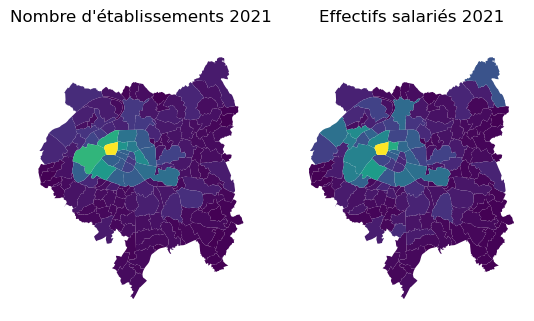

In [11]:
# Add geometry to the communes
df_GPM_grouped_with_geom = pd.merge(df_GPM_grouped, communes_GPM, left_on = 'Code commune', right_on = 'INSEE_COM', how = 'left')
df_GPM_grouped_with_geom = gpd.GeoDataFrame(df_GPM_grouped_with_geom, geometry = 'geometry')

# Final Clean-up
col_tokeep = ['Commune', 'Code commune', 'Nombre d\'établissements 2021',
       'Effectifs salariés 2021', 'geometry']
jobs_per_commune = df_GPM_grouped_with_geom[col_tokeep]

fig, [ax1,ax2] = plt.subplots(1, 2)

# turn off axes
ax1.axis('off')
ax2.axis('off')

ax1.set_title('Nombre d\'établissements 2021')
ax2.set_title('Effectifs salariés 2021')

jobs_per_commune.plot(column = 'Nombre d\'établissements 2021', legend = False, ax = ax1)
jobs_per_commune.plot(column = 'Effectifs salariés 2021', legend = False, ax = ax2)

<Axes: >

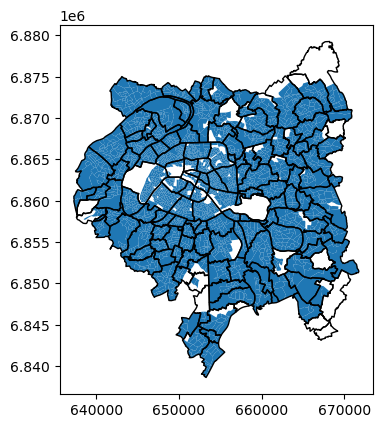

In [12]:
#--- Now on to IRIS level

# Prep the data for spatial join
jobs_per_commune = jobs_per_commune.to_crs(IRIS_GPM.crs)
IRIS_GPM['representative_point'] = IRIS_GPM.representative_point()
IRIS_GPM = IRIS_GPM.set_geometry('representative_point')

# Spatial join
IRIS_communes_GPM = gpd.sjoin(jobs_per_commune, IRIS_GPM, how= 'inner').drop(columns=['index_right'])
IRIS_communes_GPM = IRIS_communes_GPM.set_geometry('geometry_right')

# Plot to check if it worked
ax = plt.axes()
IRIS_communes_GPM.plot(ax=ax)
jobs_per_commune.plot(ax=ax, facecolor='none')

<Axes: >

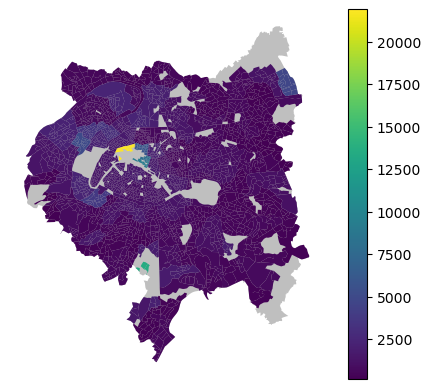

In [13]:
#--- Turning commune-level numbers into IRIS-level numbers

# Calculate the number of IRIS in each commune
IRIS_communes_GPM['Nombre d\'IRIS'] = IRIS_communes_GPM.groupby(['Commune'])['CODE_IRIS'].transform('count')

# Divide the number of jobs in each commune by the number of IRIS in the commune
IRIS_communes_GPM['Effectifs salariés 2021 par IRIS'] = IRIS_communes_GPM['Effectifs salariés 2021'] / IRIS_communes_GPM['Nombre d\'IRIS']
IRIS_communes_GPM['Nombre d\'établissements 2021 par IRIS'] = IRIS_communes_GPM['Nombre d\'établissements 2021'] / IRIS_communes_GPM['Nombre d\'IRIS']

# Plot the number of jobs per IRIS
ax = plt.axes()
ax.axis('off')
GPM.plot(facecolor = 'grey', alpha = 0.5, ax=ax)
IRIS_communes_GPM.plot(column = 'Effectifs salariés 2021 par IRIS',legend = True, ax=ax)


In [14]:
#--- Create the final jobs per IRIS dataset

col_tokeep = ['CODE_IRIS', 'Effectifs salariés 2021 par IRIS', 'Nombre d\'établissements 2021 par IRIS']
jobs_per_IRIS = IRIS_communes_GPM[col_tokeep]
jobs_per_IRIS = jobs_per_IRIS.astype('int64')

jobs_per_IRIS.head(1)

,CODE_IRIS,Effectifs salariés 2021 par IRIS,Nombre d'établissements 2021 par IRIS
4,930330103,225,52


In [15]:
total_jobs_GPM = jobs_per_IRIS['Effectifs salariés 2021 par IRIS'].sum()
total_jobs_GPM

3409213

# Median income per IRIS (TOIMPORT)

In [16]:
#TODO

# Education level per IRIS (TOIMPORT/TODO)

In [17]:
#TODO

# Active/school/total population and population density per IRIS

In [18]:
# From https://www.insee.fr/fr/statistiques/6456153?sommaire=6456166#dictionnaire
#--- Get data on the age ranges of the population 

df = pd.read_csv('data/raw/struct-pop-2019/struct-pop-2019.CSV', sep = ';')
df_meta = pd.read_csv('data/raw/struct-pop-2019/meta-struct-pop-2019.CSV', sep = ';')
df['IRIS'] = df['IRIS'].astype('string')

vars_of_interest = ['IRIS',
                    'P19_POP', # Total population
                    'P19_POP0305', # Pop 3-5 y.o -> goes to school
                    'P19_POP0610', # Pop 6-10 y.o -> goes to school
                    'P19_POP1117', # Pop 11-17 y.o -> goes to school 
                    'P19_POP1824', # Pop 18-24 y.o -> goes to work
                    'P19_POP2539', # Pop 25-39 y.o -> goes to work
                    'P19_POP4054', # Pop 40-54 y.o -> goes to work
                    'P19_POP5564', # Pop 55-64 y.o -> goes to work  
                    'COM'                
                    ]

df_meta_vars = df_meta.loc[df_meta['COD_VAR'].isin(vars_of_interest)].drop_duplicates(subset = 'COD_VAR')
df_narrow_IRIS = df.loc[(df['IRIS'].isin(IRIS_GPM['CODE_IRIS'])), df_meta_vars['COD_VAR'].values]

/var/folders/2m/lkz691q11b72bpprh6_v34_h0000gn/T/ipykernel_2884/669537842.py:4: DtypeWarning: Columns (0,1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/raw/struct-pop-2019/struct-pop-2019.CSV', sep = ';')


In [32]:
# Combine age ranges into school and active population
df_narrow_IRIS['school_pop_19'] = df_narrow_IRIS['P19_POP0305'] + df_narrow_IRIS['P19_POP0610'] + df_narrow_IRIS['P19_POP1117']
df_narrow_IRIS['active_pop_19'] = df_narrow_IRIS['P19_POP1824'] + df_narrow_IRIS['P19_POP2539'] + df_narrow_IRIS['P19_POP4054'] + df_narrow_IRIS['P19_POP5564']

# Remove useless columns
age_range_IRIS = df_narrow_IRIS.drop(columns = ['P19_POP0305', 'P19_POP0610', 'P19_POP1117',
                                                'P19_POP1824', 'P19_POP2539', 'P19_POP4054', 'P19_POP5564']) 

# Fill in missing data (median of the commune, same communes missing for both variables)
P19_pop_commune_median = age_range_IRIS.loc[age_range_IRIS['COM'] == 94022]['P19_POP'].median()
P19_pop_school_commune_median = age_range_IRIS.loc[age_range_IRIS['COM'] == 94022]['school_pop_19'].median()
P19_pop_active_commune_median = age_range_IRIS.loc[age_range_IRIS['COM'] == 94022]['active_pop_19'].median()
row1 = ['940220101', P19_pop_commune_median, P19_pop_school_commune_median, P19_pop_active_commune_median]
row2 = ['940220103', P19_pop_commune_median, P19_pop_school_commune_median, P19_pop_active_commune_median]
row3= ['940220104', P19_pop_commune_median, P19_pop_school_commune_median, P19_pop_active_commune_median]
df2 = pd.DataFrame([row1, row2, row3],
                   columns=['IRIS', 'P19_POP', 'school_pop_19', 'active_pop_19'])
age_range_IRIS = pd.concat([age_range_IRIS, df2]).drop(columns = 'COM').reset_index(drop=True)

age_range_IRIS['IRIS'] = age_range_IRIS['IRIS'].astype('string')
age_range_IRIS.shape


(2666, 4)

In [33]:
age_range_IRIS_geom = age_range_IRIS.merge(IRIS_GPM, left_on = 'IRIS', right_on = 'CODE_IRIS')
age_range_IRIS_geom = gpd.GeoDataFrame(age_range_IRIS_geom, geometry = 'geometry')

In [38]:
#--- Add population density

# Calculate the area of each polygon
age_range_IRIS_geom['area'] = age_range_IRIS_geom['geometry'].area / 1000000 #make per km2

# Calculate the population density
age_range_IRIS_geom['pop_density'] = age_range_IRIS_geom['P19_POP'] / age_range_IRIS_geom['area']
age_range_IRIS_geom['active_pop_density'] = age_range_IRIS_geom['active_pop_19'] / age_range_IRIS_geom['area']
age_range_IRIS_geom['school_pop_density'] = age_range_IRIS_geom['school_pop_19'] / age_range_IRIS_geom['area']

age_range_IRIS_geom.head(2)

,P19_POP,IRIS,school_pop_19,active_pop_19,CODE_IRIS,geometry,representative_point,area,pop_density,active_pop_density,school_pop_density
0,949.437277,751010101,120.926298,643.391695,751010101,"POLYGON ((652130.300 6862122.400, 652126.100 6...",POINT (651967.902 6862262.950),0.064002,14834.503153,10052.687376,1889.415542
1,2090.235257,751010201,150.158591,1538.800562,751010201,"POLYGON ((652203.200 6862692.000, 652214.400 6...",POINT (652222.135 6862546.900),0.079516,26287.087669,19352.168679,1888.415213


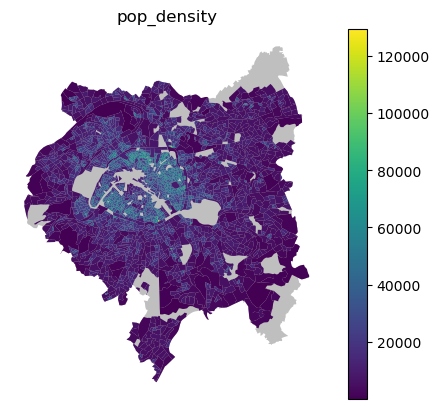

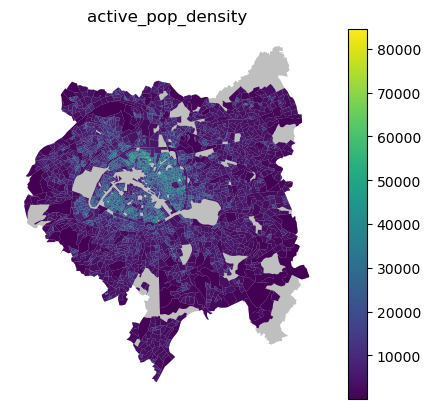

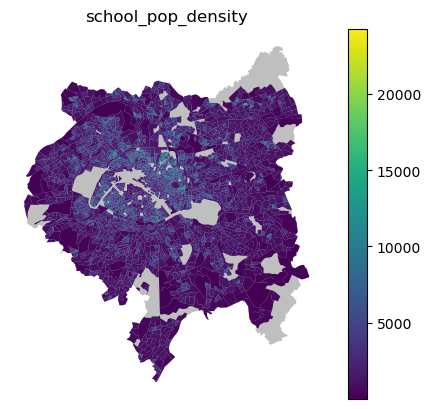

In [48]:
# Plot everything
col_toplot =['pop_density',
            'active_pop_density',
            'school_pop_density'
            ]

for col in col_toplot:
    ax = plt.axes()
    ax.axis('off')
    GPM.to_crs(crs_fr).plot(facecolor = 'grey', alpha = 0.5, ax=ax)
    age_range_IRIS_geom.plot(column = col, legend = True, ax=ax)

    plt.title(col)
    plt.savefig(f'./figures/{col}.png')
    plt.show()

# Initial job and school accessibility (TODO)

In [23]:
#TODO all

<Axes: >

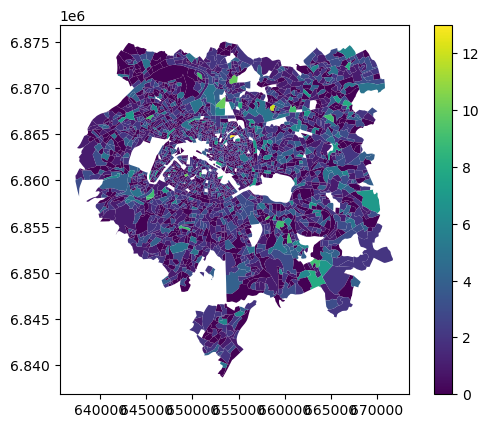

In [24]:
#--- Combine age ranges and school locations
age_school_IRIS = age_range_IRIS.merge(education_perIRIS, left_on = 'IRIS', right_on = 'CODE_IRIS', how = 'outer')
age_school_IRIS = gpd.GeoDataFrame(age_school_IRIS, geometry = 'geometry')
age_school_IRIS.plot(column = 'school_count', legend = True)

## Create the complete network with the position of schools/jobs to calculate travel times

In [25]:
#--- Get data, turn to GeoDataFrame
# Edges
edges_with_id = pd.read_csv('data/clean/initial_network_edges_complete.csv')
edges_with_id["geometry"] = edges_with_id.apply(lambda x: shapely.wkt.loads(x.geometry), axis = 1)
edges_with_id = gpd.GeoDataFrame(edges_with_id, geometry = 'geometry', crs = 4326).to_crs(2154)

# Nodes
nodes_carbike_centroids_RER_complete = pd.read_csv('data/clean/initial_network_nodes_complete.csv').drop(columns = 'attr_dict')
nodes_carbike_centroids_RER_complete["geometry"] = nodes_carbike_centroids_RER_complete.apply(lambda x: shapely.wkt.loads(x.geometry), axis = 1)
nodes_carbike_centroids_RER_complete = gpd.GeoDataFrame(nodes_carbike_centroids_RER_complete, geometry = 'geometry', crs = 4326).to_crs(2154)

# GPM
GPM = GPM.to_crs(4326)

/var/folders/2m/lkz691q11b72bpprh6_v34_h0000gn/T/ipykernel_2884/3071740452.py:8: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  nodes_carbike_centroids_RER_complete = pd.read_csv('data/clean/initial_network_nodes_complete.csv').drop(columns = 'attr_dict')


In [26]:
#--- Add the number of schools of each centroid to the dataframe
# Match the centroids to their corresponding IRIS
nodes_carbike_centroids_RER_withschools = pd.merge(nodes_carbike_centroids_RER_complete, age_school_IRIS, left_on = 'CODE_IRIS', right_on = 'CODE_IRIS', how = 'left').drop(columns = 'geometry_y').rename(columns = {'geometry_x': 'geometry'})

# Check this is empty
print(nodes_carbike_centroids_RER_withschools[(nodes_carbike_centroids_RER_withschools['centroid'] == True) & (nodes_carbike_centroids_RER_withschools['IRIS'].isnull())])

Empty GeoDataFrame
Columns: [osmid, y, x, geometry, nodetype, centroid, RER, ligne, CODE_IRIS, P19_POP, IRIS, school_pop_19, active_pop_19, school_count]
Index: []


In [27]:
#--- Add the number of jobs to the dataframe #TODO

In [28]:
# Recreate the attr_dict because python ...
nodes_carbike_centroids_RER_withschools["attr_dict"] = nodes_carbike_centroids_RER_withschools.apply(lambda x: make_attr_dict(lat = x.x,
                                                                  lon = x.y,
                                                                  pos = (x.x, x.y),
                                                                  nodetype = x.nodetype,
                                                                  centroid = x.centroid,
                                                                  RER = x.RER,
                                                                  IRIS = x.IRIS,
                                                                  children_pop = x.P19_POP_SCHOOL,
                                                                  num_schools = x.school_count),
                                                                  axis = 1) 


KeyboardInterrupt



In [ ]:
#--- Create Graph with all nodes and edges
G = nx.from_pandas_edgelist(edges_with_id, source='x', target='y', edge_attr=True)
G.add_nodes_from(nodes_carbike_centroids_RER_withschools.loc[:,["osmid", "attr_dict"]].itertuples(index = False))

# Check if all nodes and edges are present
# Both should be 0
print(len(G.nodes()) - len(nodes_carbike_centroids_RER_withschools))
print(len(G.edges()) - len(edges_with_id))

0
-20


In [ ]:
#--- Create "bikeable" network B (Anastassia)
B = G.copy()
bikeable_nodes = [node for node in B.nodes if B.nodes[node]["nodetype"]!="car"] 
B_noncar_induced = B.subgraph(bikeable_nodes).copy() 

# induced subgraph - still contains the car edges that lie between multi nodes; - exclude them:
banw = B_noncar_induced.copy()
banw.remove_edges_from([edge for edge in banw.edges if banw.edges[edge]["edgetype"]=="car"])
banw.remove_edges_from([edge for edge in banw.edges if banw.edges[edge]["edgetype"]=="RER"])

#--- Check if all nodes and edges are present
# Both should be 0
print(len(banw.nodes()) 
      - len(nodes_carbike_centroids_RER_withschools.loc[nodes_carbike_centroids_RER_withschools['nodetype'] == 'bike']))
print(len(banw.edges()) 
      - len(edges_with_id.loc[edges_with_id['edgetype'] == 'bike']) 
      - len(edges_with_id.loc[edges_with_id['edgetype'] == 'both'])) # -3?


0
-3


In [ ]:
#--- Make all networks undirected
# G = G.to_undirected()
print(nx.is_connected(G)) # True
banw = banw.to_undirected()
print(nx.is_connected(banw)) # most likely False
RERG = RERG.to_undirected()
print(nx.is_connected(RERG)) # True

True
False
True


In [ ]:
#--- Check: Routing between centroids
# Pick two random nodes with centroid = True
start_node = nodes_carbike_centroids_RER_withschools.loc[nodes_carbike_centroids_RER_withschools['centroid'] == True].sample(1)
end_node = nodes_carbike_centroids_RER_withschools.loc[nodes_carbike_centroids_RER_withschools['centroid'] == True].sample(1)

# Check if they are connected on the bike network
print(nx.has_path(banw, start_node['osmid'].iloc[0], end_node['osmid'].iloc[0])) # Can be False

# Check if they are connected on the car network
# Always True!!!!!!!
print(nx.has_path(G, start_node['osmid'].iloc[0], end_node['osmid'].iloc[0]))


False
True
False
True
True


<Axes: >

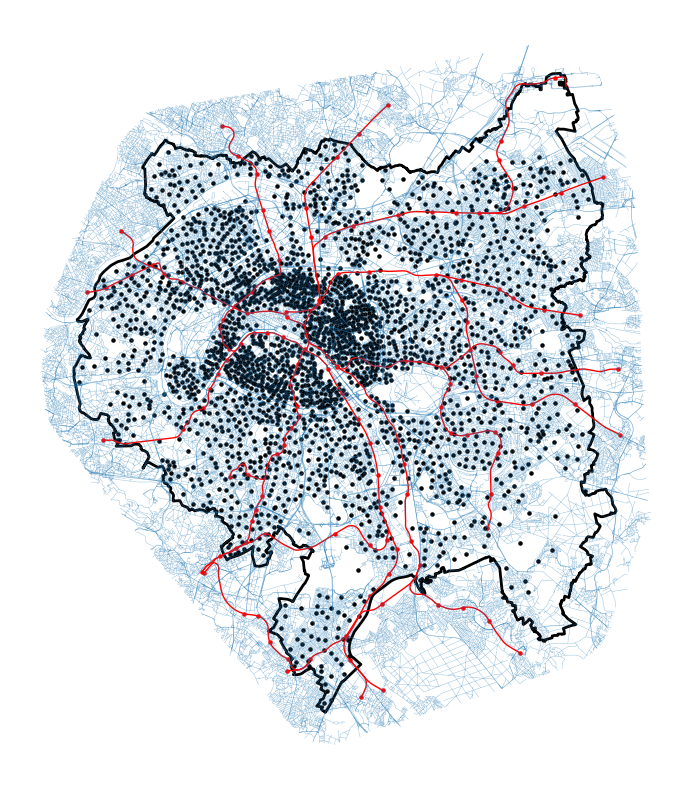

In [ ]:
#--- Plot of everything for glory
plt.rcParams['figure.figsize'] = (10, 10)

ax = plt.axes()
plt.axis('off')
edges_with_id.loc[edges_with_id['edgetype'] == 'RER'].plot(ax=ax, linewidth = 1, alpha = 1, edgecolor = 'red')
edges_with_id.loc[edges_with_id['edgetype'] != 'RER'].plot(ax=ax, linewidth = 0.3, alpha = 0.5)


# nodes_carbike_centroids_RER_complete.loc[(nodes_carbike_centroids_RER_complete['RER'] == False) & (nodes_carbike_centroids_RER_complete['centroid'] == False)].plot(ax=ax, markersize = 0.05, facecolor = 'green', alpha = 0.5)
nodes_carbike_centroids_RER_withschools.loc[nodes_carbike_centroids_RER_withschools['RER'] == True].plot(ax=ax, markersize = 5, facecolor = 'red', alpha = 1)
nodes_carbike_centroids_RER_withschools.loc[nodes_carbike_centroids_RER_withschools['centroid'] == True].plot(ax=ax, markersize = 5, facecolor = 'black', alpha = 1)

GPM.to_crs(2154).plot(ax=ax, facecolor = 'none', linewidth = 2)


## Find shortest path to nearest school (unnecessary but can be modified to calculate school and job accessibility)

In [ ]:
#--- Separate centroids by presence/absence of schools
centroids_without_schools = list(nodes_carbike_centroids_RER_withschools.loc[(nodes_carbike_centroids_RER_withschools['centroid'] == True) & (nodes_carbike_centroids_RER_withschools['school_count'] == 0)]['osmid'])
print(len(centroids_without_schools), ' IRIS don\'t have schools')

centroids_with_schools = list(nodes_carbike_centroids_RER_withschools.loc[(nodes_carbike_centroids_RER_withschools['centroid'] == True) & (nodes_carbike_centroids_RER_withschools['school_count'] > 0)]['osmid'])
print(len(centroids_with_schools), ' IRIS have schools')

921
1745


In [ ]:
#--- Search for shortest path from no-school to school
graph = G
set1 = centroids_without_schools
set2 = centroids_with_schools
original_set2 = set2  
ranges_dict = {}
filtered_set2_dict = {}

# Calculate and store the ranges for each node in set1
for node_set1 in set1:
    # Create lat and lon ranges for each node of set1
    if node_set1 not in G:
        ranges_dict[node_set1] = None
        continue

    lat = G.nodes[node_set1]['lat']
    lon = G.nodes[node_set1]['lon']
    buffer = 0.15  # Play around with this

    lat_min = lat - buffer
    lat_max = lat + buffer
    lon_min = lon - buffer
    lon_max = lon + buffer

    ranges_dict[node_set1] = {'lat_min': lat_min, 'lat_max': lat_max, 'lon_min': lon_min, 'lon_max': lon_max}

    # Filter set2 based on latitude and longitude ranges
    filtered_set2 = []
    for node_set2 in original_set2:
        if node_set2 not in G:
            continue
        latitude = G.nodes[node_set2]['lat']  # Access the latitude attribute of the node
        longitude = G.nodes[node_set2]['lon']  # Access the longitude attribute of the node
        if lat_min <= latitude <= lat_max and lon_min <= longitude <= lon_max:
            filtered_set2.append(node_set2)

    filtered_set2_dict[node_set1] = filtered_set2

# Function to calculate the shortest path for all nodes of set1
def process_node(node_set1):
    if node_set1 not in G:
        return node_set1, None, None

    ranges = ranges_dict[node_set1]
    if ranges is None:
        return node_set1, None, None

    filtered_set2 = filtered_set2_dict[node_set1]

    if not filtered_set2:
        return node_set1, None, None
        
    if node_set1 not in G or not all(node in G for node in filtered_set2):
        return node_set1, None, None
    
    
    shortest_paths = nx.single_source_dijkstra_path_length(graph, node_set1)
    shortest_paths = {node2: distance for node2, distance in shortest_paths.items() if node2 in filtered_set2}
    closest_node, shortest_distance = min(shortest_paths.items(), key=lambda x: x[1])

    return node_set1, closest_node, shortest_distance

if __name__ == '__main__':
    # Number of processes (cores) to use for parallel processing
    num_processes = 4

    # Create a pool of processes
    pool = mp.Pool(processes=num_processes)

    # Apply the function to each node in set1 using parallel processing
    results = pool.map(process_node, set1)

    # Close the pool
    pool.close()
    pool.join()
 
# Create a dictionary from the results
results_dict = {node_set1: {'closest_node_set2': closest_node_set2, 'path_length': path_length, 'IRIS': int(G.nodes[node_set1]['IRIS'])} for node_set1, closest_node_set2, path_length in results}


/Users/auriane/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/multiprocess/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x1108540a0>
  self.pid = os.fork()
/Users/auriane/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/multiprocess/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x1108540a0>
  self.pid = os.fork()
/Users/auriane/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/multiprocess/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x1108540a0>
  self.pid = os.fork()
/Users/auriane/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/multiprocess/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x1108540a0>
  self.pid = os.fork()


# Final clean-up and save (TOFIX)

In [ ]:
age_school_IRIS.head(3)

,P19_POP,IRIS,P19_POP_SCHOOL,CODE_IRIS,school_count,geometry,vulnerability_simple,area,pop_density
0,949.437277,751010101,120.926298,751010101,1,"POLYGON ((652130.300 6862122.400, 652126.100 6...",0,0.064002,14834.503153
1,2090.235257,751010201,150.158591,751010201,0,"POLYGON ((652203.200 6862692.000, 652214.400 6...",1,0.079516,26287.087669
2,1657.745711,751010202,182.822372,751010202,1,"POLYGON ((651529.900 6862629.400, 651540.100 6...",0,0.070816,23409.208799
3,2369.336175,751010203,266.460598,751010203,0,"POLYGON ((651714.000 6862876.100, 651773.000 6...",1,0.103734,22840.490963
4,2155.612624,751010204,264.227427,751010204,0,"POLYGON ((652196.800 6862680.900, 651848.800 6...",1,0.067961,31718.465738
...,...,...,...,...,...,...,...,...,...
2661,3134.273605,950181002,716.930804,950181002,1,"POLYGON ((647763.400 6873263.800, 647671.200 6...",0,0.248110,12632.585140
2662,2257.580060,950181003,477.573253,950181003,0,"POLYGON ((647139.800 6873018.700, 647161.700 6...",1,0.483725,4667.068631
2663,2570.192234,940220101,503.315354,940220101,5,"POLYGON ((656500.900 6852179.200, 656480.600 6...",0,0.549693,4675.686672
2664,2570.192234,940220103,503.315354,940220103,1,"POLYGON ((656445.700 6851426.800, 656452.700 6...",0,0.242338,10605.812483


In [ ]:
# Clean up the columns
col_tokeep = ['osmid', 'CODE_IRIS', 'nodetype', 'centroid', 'RER', 'vulnerability_simple_x', 'vulnerability_pathlength', 'path_length', 'P19_POP_x', 'pop_density', 'geometry']

nodes_carbike_centroids_RER_withschools_final = nodes_carbike_centroids_RER_withschools.merge(age_school_IRIS.drop(columns = 'geometry'), left_on='CODE_IRIS', right_on='CODE_IRIS', how='left')
nodes_carbike_centroids_RER_withschools_final = nodes_carbike_centroids_RER_withschools_final[col_tokeep]

nodes_carbike_centroids_RER_withschools_final = nodes_carbike_centroids_RER_withschools_final.T.drop_duplicates().T

nodes_carbike_centroids_RER_withschools_final.head(1)

,osmid,CODE_IRIS,nodetype,centroid,RER,vulnerability_simple_x,P19_POP_x,pop_density,geometry
0,0,NaN,bike,False,True,NaN,NaN,NaN,POINT (656121.8462992132 6845998.146596032)


In [ ]:
# Clean up the missing values
# nodes_carbike_centroids_RER_withschools_final['vulnerability_pathlength'] = nodes_carbike_centroids_RER_withschools_final['vulnerability_pathlength'].fillna(0)
# nodes_carbike_centroids_RER_withschools_final['vulnerability_simple_x'] = nodes_carbike_centroids_RER_withschools_final['vulnerability_simple_x'].fillna(0)
nodes_carbike_centroids_RER_withschools_final['pop_density'] = nodes_carbike_centroids_RER_withschools_final['pop_density'].fillna(0)
nodes_carbike_centroids_RER_withschools_final['P19_POP_x'] = nodes_carbike_centroids_RER_withschools_final['P19_POP_x'].fillna(0)

In [ ]:
nodes_carbike_centroids_RER_withschools_final.head()

,osmid,CODE_IRIS,nodetype,centroid,RER,vulnerability_simple_x,P19_POP_x,pop_density,geometry
0,0,NaN,bike,False,True,0.0,0.0,0.0,POINT (656121.8462992132 6845998.146596032)
1,1,NaN,bike,False,True,0.0,0.0,0.0,POINT (650849.5186991219 6863778.762496102)
2,2,NaN,bike,False,True,0.0,0.0,0.0,POINT (672031.758199496 6856263.685896073)
3,3,NaN,bike,False,True,0.0,0.0,0.0,POINT (648906.4361990826 6872840.74119613)
4,4,NaN,bike,False,True,0.0,0.0,0.0,POINT (664035.4267993531 6856434.9975960655)


In [ ]:
nodes_carbike_centroids_RER_withschools_final.isnull().sum()

osmid                          0
CODE_IRIS                 115687
nodetype                       0
centroid                       0
RER                            0
vulnerability_simple_x         0
P19_POP_x                      0
pop_density                    0
geometry                       0
dtype: int64

In [ ]:
nodes_carbike_centroids_RER_withschools_final.loc[nodes_carbike_centroids_RER_withschools_final['centroid'] == True].isnull().sum()


osmid                     0
CODE_IRIS                 0
nodetype                  0
centroid                  0
RER                       0
vulnerability_simple_x    0
P19_POP_x                 0
pop_density               0
geometry                  0
dtype: int64

In [ ]:
nodes_carbike_centroids_RER_withschools_final.loc[nodes_carbike_centroids_RER_withschools_final['centroid'] == True]['CODE_IRIS'].nunique()

2666

In [ ]:
#--- Save the results 

#Give columns better names
nodes_carbike_centroids_RER_withschools_final = nodes_carbike_centroids_RER_withschools_final.rename(columns = {'vulnerability_simple_x': 'vulnerability_simple',
                                                                                                                 'P19_POP_x': 'P19_POP',
                                                                                                                 'path_length_x': 'path_length'})

nodes_carbike_centroids_RER_withschools_final.to_csv('data/clean/initial_network_nodes_school_complete.csv', index = False)